# Training Notebook

The aim of this notebook is to provide an overview of the model creation process carried out for this project. It assumes that the relevant sections of the main project notebook have been read, and therefore omits basic information covered at the beginning of ```project.ipynb```. As it is supplementary to the main project, and only intended as a brief overview (to guide readers as to how they might carry out a similar data collection process), code in this notebook is sparsely commented.

## Loading Training Data

Training a model for the regression task of measuring emotion intensity requires human-labelled training data. For this, I am using the [Tweet Emotion Intensity Dataset]('https://saifmohammad.com/WebPages/TweetEmotionIntensity-dataviz.html') (Saif et al., 2017). To create this dataset, human annotators were repeatedly presented with tweets and asked to select those with the highest and lowest intensity. 

First, the dataset was loaded and processed to remove emoticons and hashtags, which are thought not to contain useful semantic information (Saif et al., 2017). After loading the data, I split it into training and test data at a ratio of 80-20.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from supplementary_code import process_df_text
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 2)
              
%matplotlib inline

sns.set(style="whitegrid")

def load_df(file_path):
    # Load dataset.
    df = pd.read_csv(file_path, sep='\t', header=None)

    # Remove the 'Tweet ID' column, as this is unnecessary.
    df.columns = ['TweetID', 'Tweet', 'Emotion', 'Intensity']
    df = df.drop(columns=['TweetID'])

    # Remove hashtags and hyperlinks.
    df = process_df_text(df, 'Tweet')

    df['Intensity'] = df['Intensity'].apply(lambda x: float(x))
    
    return df

# Output Train, Dev, Test
def create_dataframes(emotion):
    train_df = load_df(file_path=f'data/intensity_data/{emotion}-ratings-0to1.train.csv')
    dev_df = load_df(file_path=f'data/intensity_data/{emotion}-ratings-0to1.dev.gold.csv')
    test_df = load_df(file_path=f'data/intensity_data/{emotion}-ratings-0to1.test.gold.csv')

    combined_df = pd.concat([train_df, dev_df, test_df], ignore_index=True)
    train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=101)

    return train_df, test_df

# Create dataframes.
anger_train_df, anger_test_df = create_dataframes('anger')
fear_train_df, fear_test_df = create_dataframes('fear')
sadness_train_df, sadness_test_df = create_dataframes('sadness')
joy_train_df, joy_test_df = create_dataframes('joy')

To ensure this worked correctly, I displayed the first rows of ```anger_train_df```. 

In [13]:
anger_train_df.head()

,Tweet,Emotion,Intensity
1020,@Alex_Philip2648 it's a step up from boiling b...,anger,0.29
320,@NM_NickNocturne Incentivise people to roam th...,anger,0.54
98,I wonder what American city will be next to pr...,anger,0.71
1224,The ppl on here defending cops as they continu...,anger,0.75
761,Houston might lose a coach tomorrow or by midn...,anger,0.31


Next, I investigated the size of the training dataframes for each emotion.

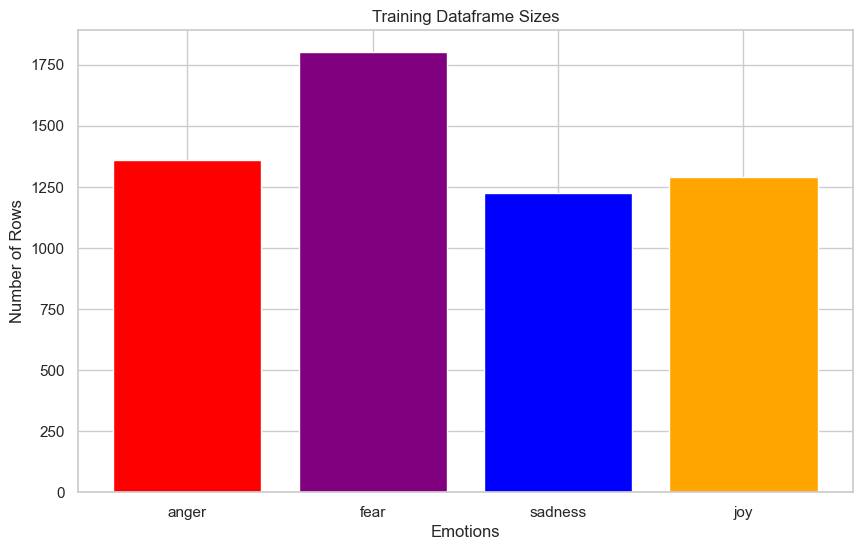

In [14]:
emotion_counts = [anger_train_df.shape[0], fear_train_df.shape[0], sadness_train_df.shape[0], joy_train_df.shape[0]]
emotions = ['anger', 'fear', 'sadness', 'joy']

plt.figure(figsize=(10, 6))
plt.bar(emotions, emotion_counts, color=['red', 'purple', 'blue', 'orange'])
plt.xlabel('Emotions')
plt.ylabel('Number of Rows')
plt.title('Training Dataframe Sizes')
plt.show()


Machine learning datasets are often tens of thousands of entries in size. As there a few entries in the training data, a network pre-trained on a large amount of text will be used, instead of training the models from scratch. 

BERT (Bidirectional Encoder Representations from Transformers) is a variation of the transformer model that was pre-trained on a vast amount of text (Devlin et al., 2018). I used the ```transformers``` library to load a model pretrained for a sentiment classification task (i.e. classifying tweets based on their negative, neutral or positive sentiment).

## Model Creation

First, I loaded the BERT model. I trained a basic BERT model, ```bert-base-uncased```, on a sentiment analysis task. Given a tweet, this base model outputs three values which represent the probability that the tweet has a positive, neutral or negative sentiment respectively. For clarity, a visualisation of the initial network is provided below:

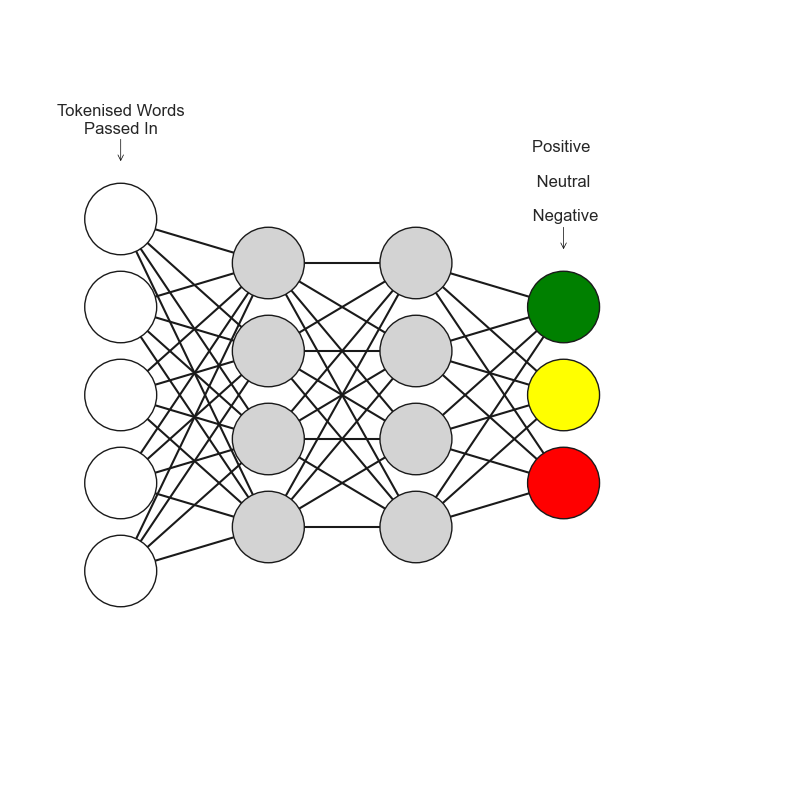

In [15]:
from supplementary_code import NeuralNetworkDiagram, add_standard_labels
import matplotlib.pyplot as plt 

sentiment_nn_diagram = NeuralNetworkDiagram([5, 4, 4, 3])
sentiment_nn_diagram.change_layer_colour(0, 'w')
sentiment_nn_diagram.change_neuron_colour(3, 0, 'red')
sentiment_nn_diagram.change_neuron_colour(3, 1, 'yellow')
sentiment_nn_diagram.change_neuron_colour(3, 2, 'green')

add_standard_labels(sentiment_nn_diagram, output_layer_label="Positive \n\n Neutral \n\n Negative", 
                    input_layer_label="Tokenised Words\nPassed In", add_hidden_layer_labels=False)

sentiment_nn_diagram.draw();

Below, the base model is loaded.

In [19]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import torch.nn as nn

device = torch.device('mps')

# Instantiate the model with the correct number of labels it was originally trained with
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  # Set the number of labels
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The task that the intensity prediction models will be trained for is regression, not classification. Therefore, a different architecture is required. Below, the base model has its final layer removed and replaced with a single neuron, that outputs floating point values between 0 and 1 – suitable for a regression task. Throughout the fine-tuning process, the network will be trained to provide an output that minimises the Mean-Squared-Error (MSE) loss between the sigmoid layer output and the human-labelled training data.

In [20]:

# Add a sigmoid layer. Therefore the neural network will output a value between 0 and 1.
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1), # Replace the original 3-neuron classification layer with a 1-neuron layer.
    nn.Sigmoid()  # Use sigmoid to constrain its output between 0 and 1
)

# Move modified model to GPU.
model.to(device)

# Save the modified model for regression
modified_model_path = 'data/models'
torch.save(model.state_dict(), f'{modified_model_path}/base_model.pt')

print(f"Modified regression model's state_dict saved to {modified_model_path}/base_model.pt")

Modified regression model's state_dict saved to data/models/base_model.pt


Finally, the state (weights and biases) of the network are loaded.

In [ ]:
# Load the checkpoint into the model
checkpoint_path = 'data/models/sentiment_model/sentiment_model.pt'
state = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state)

Next, four models are created by training four instances of the base model, one on each emotion in the dataset.

In [25]:
from math import sqrt
from sklearn.metrics import mean_squared_error
import logging
from tqdm import tqdm

def evaluate_model(model, val_loader, device, loss_fn):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits.squeeze(-1), labels)
            val_loss += loss.item()
            all_preds.extend(outputs.logits.squeeze(-1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_rmse = sqrt(mean_squared_error(all_labels, all_preds))
    return val_loss, val_rmse

def train_and_evaluate(train_loader, test_loader, model, device, epoch, optimizer, scheduler, emotion, loss_fn):
    test_losses = []
    
    # Training phase
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits.squeeze(-1), labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    logging.info(f"Epoch {epoch} | Training Loss: {avg_train_loss:.4f}")

    # Save the model after each epoch
    torch.save(model.state_dict(), f"models/emotion_models/{emotion}/model_epoch_{epoch}.pt")

    test_loss, test_rmse = evaluate_model(model, test_loader, device, loss_fn)
    logging.info(f"Test Loss: {test_loss:.4f} | Test RMSE: {test_rmse:.4f}")
    test_losses.append(test_loss)

    return test_losses

from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, get_linear_schedule_with_warmup

class IntensityDataset(Dataset):
    def __init__(self, tweets, intensities, tokenizer, max_len):
        self.encodings = tokenizer(tweets, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
        self.labels = torch.tensor(intensities, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    
    def __len__(self):
        return len(self.labels)

def prepare_data_loaders(train_df, test_df, tokenizer, batch_size, max_length):
    # Ensure the 'Tweet' column is a list of strings
    train_texts = train_df['Tweet'].astype(str).tolist()
    train_intensities = train_df['Intensity'].tolist()
    train_labels = torch.tensor(train_intensities, dtype=torch.float)

    # Create a dataset and data loader for training
    train_dataset = IntensityDataset(train_texts, train_labels, tokenizer, max_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Ensure the 'Tweet' column is a list of strings for the test data as well
    test_texts = test_df['Tweet'].astype(str).tolist()
    test_intensities = test_df['Intensity'].tolist()
    test_labels = torch.tensor(test_intensities, dtype=torch.float)

    # Create a dataset and data loader for testing
    test_dataset = IntensityDataset(test_texts, test_labels, tokenizer, max_length)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

def plot_losses(emotion_losses):
    emotion_colors = {
        'anger': 'red',
        'fear': 'purple',
        'sadness': 'blue',
        'joy': 'yellow'
    }
    
    for emotion, losses in emotion_losses.items():
        plt.plot(range(1, len(losses) + 1), losses, label=f'{emotion} test loss', color=emotion_colors[emotion])

    plt.xlabel('Iterations')
    plt.ylabel('Test RMSE')
    plt.title('Average Test RMSE Over Iterations by Emotion')
    plt.legend()
    plt.show()


def process(emotion, epoch):
    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  
    batch_size = 2
    max_length = 240
    learning_rate = 1e-5

    if epoch == 1:
        # Load base model.
        state = torch.load('models/emotion_models/base_model.pt')
        model.load_state_dict(state)
        
    # Prepare data loaders for the specified emotion
    else:
        state = torch.load(f'models/emotion_models/{emotion}/model_epoch_{epoch - 1}.pt')
        model.load_state_dict(state)

    if emotion == 'anger':
        train_loader, test_loader = prepare_data_loaders(anger_train_df, anger_test_df, tokenizer, batch_size, max_length)
    elif emotion == 'fear':
        train_loader, test_loader = prepare_data_loaders(fear_train_df, fear_test_df, tokenizer, batch_size, max_length)
    elif emotion == 'sadness':
        train_loader, test_loader = prepare_data_loaders(sadness_train_df, sadness_test_df, tokenizer, batch_size, max_length)
    elif emotion == 'joy':
        train_loader, test_loader = prepare_data_loaders(joy_train_df, joy_test_df, tokenizer, batch_size, max_length)
    else:
        print(f"Error: Emotion '{emotion}' not in list: anger, fear, sadness, joy")

    model.to(device)

    # Define the optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Define the loss function
    loss_fn = torch.nn.MSELoss()

    # Train and evaluate the model
    return train_and_evaluate(train_loader, test_loader, model, device, epoch, optimizer, scheduler, emotion, loss_fn)


anger_test_losses, fear_test_losses, sadness_test_losses, joy_test_losses = [], [], [], []
epochs = 50
for epoch in range(epochs):
    print("anger epoch", epoch + 1)
    anger_test_losses.extend(process('anger', epoch + 1))
    
    print("fear epoch", epoch + 1)
    fear_test_losses.extend(process('fear', epoch + 1))
    
    print("sadness epoch", epoch + 1)
    sadness_test_losses.extend(process('sadness', epoch + 1))

    print("joy epoch", epoch + 1)
    joy_test_losses.extend(process('joy', epoch + 1))

I plotted the losses for each epoch, for each model, and selected the models with the best performance during the data collection steps.

In [ ]:
def plot_losses(emotion_losses):
    emotion_colors = {
        'anger': 'r',
        'fear': 'purple',
        'sadness': 'b',
        'joy': 'y'
    }
    
    for emotion, losses in emotion_losses.items():
        plt.plot(range(1, len(losses) + 1), losses, label=f'{emotion} test loss', color=emotion_colors[emotion])

    plt.xlabel('Iterations')
    plt.ylabel('Test RMSE')
    plt.title('Average Test RMSE Over Iterations by Emotion')
    plt.legend()
    plt.show()

emotion_losses = {
'anger': [sqrt(loss) for loss in anger_test_losses],
'fear': [sqrt(loss) for loss in fear_test_losses],
'sadness': [sqrt(loss) for loss in sadness_test_losses],
'joy':  [sqrt(loss) for loss in joy_test_losses]
}

plot_losses(emotion_losses)

To visualise the performance of the best models we can make a scatter plot comparing actual vs predicted intensity values for each model's test data. 

I have chosen RMSE rather than MSE, as RMSE directly corresponds to percentage error (and is therefore easier to understand).

/var/folders/b6/tvn5hxb174732ns7m01vcfgr0000gn/T/ipykernel_60188/1960499854.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(intensities, dtype=torch.float)
/var/folders/b6/tvn5hxb174732ns7m01vcfgr0000gn/T/ipykernel_60188/1960499854.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(intensities, dtype=torch.float)
Evaluating: 100%|██████████| 171/171 [00:11<00:00, 14.70it/s]
/var/folders/b6/tvn5hxb174732ns7m01vcfgr0000gn/T/ipykernel_60188/1960499854.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.t

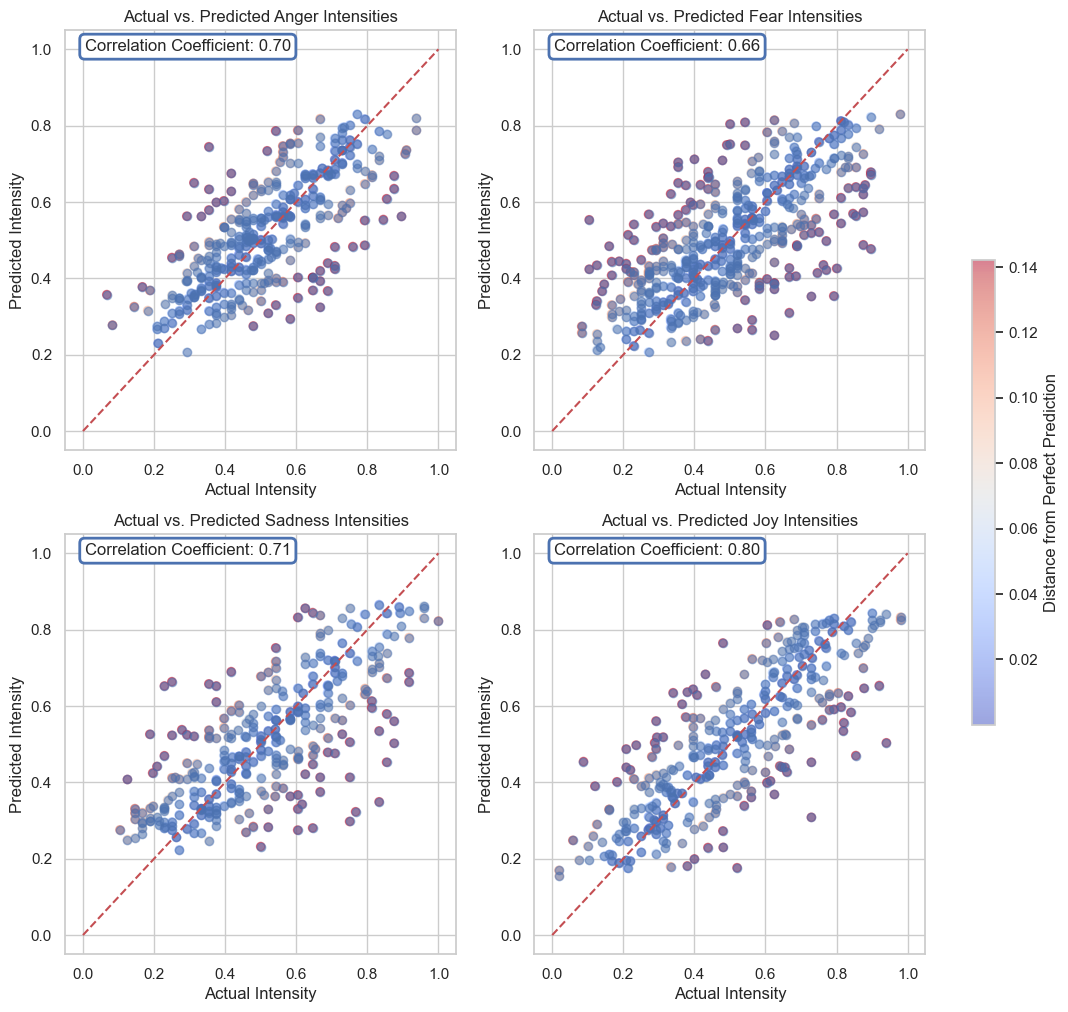

In [26]:
from tqdm import tqdm
from scipy.stats import pearsonr
import numpy as np

def evaluate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode.
    predictions = []
    actuals = []
    with torch.no_grad():  # No need to track gradients for evaluation.
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze(-1)  # Assuming the model includes the sigmoid already.
            predictions.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy.
            actuals.extend(labels.cpu().numpy())  # Move actual labels to CPU and convert to numpy.
    return actuals, predictions

def distance_from_diagonal(x, y):
    """Calculate the distance of a point from the diagonal y = x."""
    return abs(y - x) / np.sqrt(2)  # Distance from the line y = x


evaluation_results = {}

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size = 2

state = torch.load(f'data/models/anger_model/model_epoch_2.pt')
model.load_state_dict(state)
_, test_loader = prepare_data_loaders(anger_train_df, anger_test_df, tokenizer, batch_size, max_length=240)
anger_actuals, anger_predictions = evaluate_model(model, test_loader, device)
evaluation_results['anger'] = anger_actuals, anger_predictions

state = torch.load(f'data/models/fear_model/model_epoch_2.pt')
model.load_state_dict(state)
_, test_loader = prepare_data_loaders(fear_train_df, fear_test_df, tokenizer, batch_size, max_length=240)
fear_actuals, fear_predictions = evaluate_model(model, test_loader, device)
evaluation_results['fear'] = fear_actuals, fear_predictions


state = torch.load(f'data/models/sadness_model/model_epoch_3.pt')
model.load_state_dict(state)
_, test_loader = prepare_data_loaders(sadness_train_df, sadness_test_df, tokenizer, batch_size, max_length=240)
sadness_actuals, sadness_predictions = evaluate_model(model, test_loader, device)
evaluation_results['sadness'] = sadness_actuals, sadness_predictions


state = torch.load(f'data/models/joy_model/model_epoch_3.pt')
model.load_state_dict(state)
_, test_loader = prepare_data_loaders(joy_train_df, joy_test_df, tokenizer, batch_size, max_length=240)
joy_actuals, joy_predictions = evaluate_model(model, test_loader, device)
evaluation_results['joy'] = joy_actuals, joy_predictions

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()  # Flatten the 2D array of axes for easy indexing

all_distances = []
for emotion in evaluation_results.keys():
    actuals, predictions = evaluation_results[emotion]
    distances = [distance_from_diagonal(a, p) for a, p in zip(actuals, predictions)]
    all_distances.extend(distances)
min_dist, max_dist = min(all_distances), max(all_distances)

for i, emotion in enumerate(evaluation_results.keys()):
    actuals, predictions = evaluation_results[emotion]
    distances = np.array([distance_from_diagonal(a, p) for a, p in zip(actuals, predictions)])

    correlation_coef, _ = pearsonr(actuals, predictions)
    # Create visualizations or calculate regression metrics.
    scatter = axs[i].scatter(actuals, predictions, alpha=0.5, c=distances, cmap='coolwarm', vmin=min_dist, vmax=max_dist - 0.2)
    axs[i].scatter(actuals, predictions, alpha=0.5)
    axs[i].plot([0, 1], [0, 1], 'r--')  # Perfect predictions line
    axs[i].set_title(f'Actual vs. Predicted {emotion.capitalize()} Intensities')
    axs[i].set_xlabel('Actual Intensity')
    axs[i].set_ylabel('Predicted Intensity')
    axs[i].annotate(f'Correlation Coefficient: {correlation_coef:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                 fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2))
    axs[i].grid(True)

color_bar = fig.colorbar(scatter, ax=axs, orientation='vertical', fraction=0.025, pad=0.05)
color_bar.set_label('Distance from Perfect Prediction')

plt.show()

Due to the large sample size this project will be working with, I have decided that the performance is acceptable.